In [90]:
from PIL import Image
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
def convertir_imagen_vector(ruta_relativa_imagen):
    '''
    Convierte una imagen en escala de grises a un vector de una dimensión.
    Parámetros:
    ruta_relativa_imagen: str, ruta relativa de la imagen a convertir desde donde se está ejecutando esta función.
    Retorna:
    vector_imagen: numpy array, vector de una dimensión con los valores de los pixeles de la imagen.
    [pixel_1[rojo], pixel_1[verde], pixel_1[azul], pixel_2[rojo], pixel_2[verde], pixel_2[azul], ...]
    '''
    imagen_escala_grises = Image.open(ruta_relativa_imagen).convert('L')
    vector_imagen = np.array(imagen_escala_grises).flatten()
    return vector_imagen

Ejemplo de como cargar 600 imagenes

In [91]:
df_pulmones_entrenamiento = pd.read_csv('../../datasets/covid/usable/train/train.csv')
df_pulmones_pruebas = pd.read_csv('../../datasets/covid/usable/test/test.csv')
df_pulmones_entrenamiento.head()

,filename,patient_id,class,data_source,x1,y1,x2,y2,confidence
0,sub-S308658_ses-E30977_run-1_bp-chest_vp-ap_dx...,S308658,positive,bimcv,0.431250,0.546875,0.862500,0.875000,0.740234
1,sub-S333807_ses-E70861_run-1_bp-chest_vp-pa_cr...,S333807,positive,bimcv,0.517187,0.410937,0.765625,0.665625,0.898926
2,sub-S329071_ses-E58766_run-1_bp-chest_vp-pa_cr...,S329071,positive,bimcv,0.567187,0.428125,0.809375,0.818750,0.937500
3,sub-S308216_ses-E24755_run-1_bp-chest_vp-ap_dx...,S308216,positive,bimcv,0.485938,0.367188,0.865625,0.578125,0.738770
4,sub-S318051_ses-E37347_run-1_bp-chest_vp-pa_cr...,S318051,positive,bimcv,0.535937,0.473437,0.890625,0.678125,0.854004


In [92]:
print(df_pulmones_entrenamiento.shape)

(12000, 9)


In [93]:
df_pulmones_muestra_entrenamiento = df_pulmones_entrenamiento.sample(
    n=1200,
    random_state=42
)
df_pulmones_muestra_pruebas = df_pulmones_pruebas.sample(
    n=200,
    random_state=42
)
df_pulmones_muestra_entrenamiento.shape, df_pulmones_muestra_pruebas.shape

((1200, 9), (200, 9))

In [94]:
ruta_base_directorio_imagenes = '../../datasets/covid/usable/train/radiografias/'
df_pulmones_muestra_entrenamiento['ruta_completa_imagen'] = ruta_base_directorio_imagenes + df_pulmones_muestra_entrenamiento['filename']
vectores = df_pulmones_muestra_entrenamiento['ruta_completa_imagen'].apply(convertir_imagen_vector).tolist()

In [95]:
vectores[0].shape #matriz de 224*224 = 50176 columnas

(50176,)

In [96]:
ruta_base_directorio_imagenes = '../../datasets/covid/usable/test/radiografias/'
df_pulmones_muestra_pruebas['ruta_completa_imagen'] = ruta_base_directorio_imagenes + df_pulmones_muestra_pruebas['filename']
vectores_pruebas = df_pulmones_muestra_pruebas['ruta_completa_imagen'].apply(convertir_imagen_vector).tolist()

In [97]:
X = np.array(vectores)
X_pruebas = np.array(vectores_pruebas)
# 600 muestras, 50176 columnas
y = LabelEncoder().fit_transform(df_pulmones_muestra_entrenamiento['class'])
y_pruebas = LabelEncoder().fit_transform(df_pulmones_muestra_pruebas['class'])
X.shape, y.shape, X_pruebas.shape, y_pruebas.shape

((1200, 50176), (1200,), (200, 50176), (200,))

Muestra de que dichos vectores siguen siendo nuestras imágenes

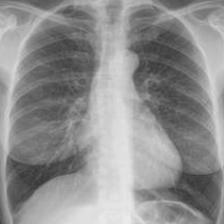

In [98]:
imagen_1 = X[0].reshape(224, 224)
display(Image.fromarray(imagen_1))

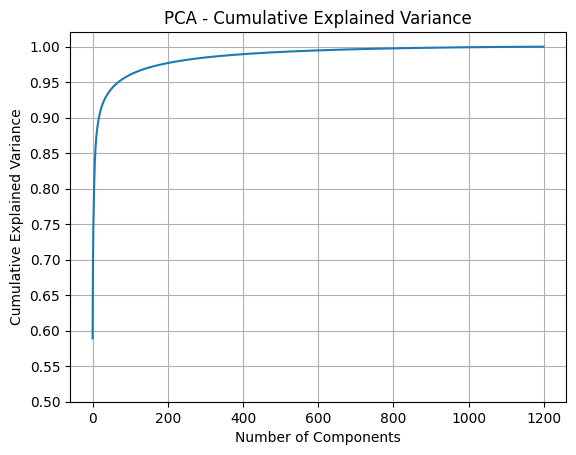

In [100]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
std = StandardScaler()
std.fit(X)
X_std = std.transform(X)
pca = PCA()
pca.fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.yticks(np.arange(0.5,1.05,0.05))
plt.grid()
plt.show()

In [104]:
n_componentes = 0.95 # 95% de la varianza explicada
std = StandardScaler()
std.fit(X)
X_std = std.transform(X)
pca = PCA(n_components=n_componentes)
X_pca = pca.fit_transform(X_std)
X_test_std = std.transform(X_pruebas)
X_test_pca = pca.transform(X_test_std)
print(f'Número de componentes: {pca.n_components_}')
X_pca.shape, X_test_pca.shape

Número de componentes: 70


((1200, 70), (200, 70))

In [107]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_pca, y)
accuracy = knn.score(X_test_pca, y_pruebas)
acc_entrenamiento = knn.score(X_pca, y)
print(f'Accuracy Entrenamiento: {acc_entrenamiento:.2f}')
print(f'Accuracy: {accuracy:.2f}')

Accuracy Entrenamiento: 0.84
Accuracy: 0.43
